In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, randint
from datetime import datetime, timedelta
from sklearn.mixture import GaussianMixture

In [2]:
def compute_z(p, degree=2):
    z = (p - 1/degree) / np.sqrt(p*(1-p))
    return z

In [3]:
def bet_size(z_stat, x=1):
    return x * (2*norm.cdf(z_stat) - 1)

#### Plot the bet size as a function of the maximum predicted probability

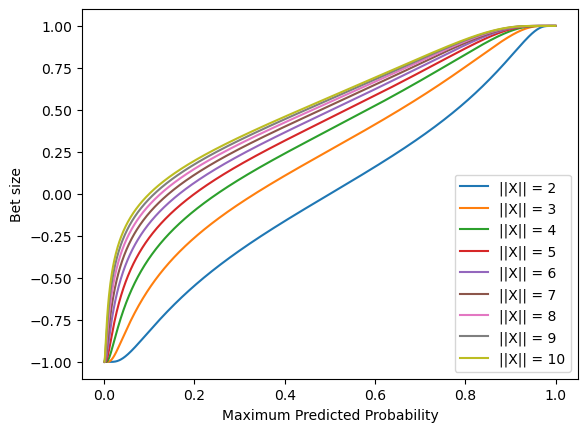

In [4]:
fig, ax = plt.subplots()
probs = np.linspace(0, 1, 1000)
probs = probs[1:-1]
for d in range(2, 11):
    z_stats = [compute_z(p, d) for p in probs]
    sizes = [bet_size(z) for z in z_stats]
    ax.plot(probs, sizes, label="||X|| = {}".format(d))
ax.set_xlabel("Maximum Predicted Probability")
ax.set_ylabel("Bet size")
ax.legend()
plt.show()

#### Computing The Average Bet Size

In [6]:
u_dist = uniform(loc=0.5, scale=0.5)
N = 100000
X = u_dist.rvs(N)
df = pd.DataFrame(X, columns=['X'])

In [7]:
# Compute bet size for each probability and randomly assign short (negative) or long (positive) positions
df['bet_size'] = df.X.apply(compute_z).apply(bet_size).apply(lambda x: x * np.random.choice([-1, 1]))
df['date'] = pd.date_range(end=datetime.now().date(), periods=N, freq='D')
df['day_shift'] = randint(low=1, high=26).rvs(N)
df['t1'] = df.date + df.day_shift.apply(timedelta)
df.set_index('date', inplace=True)

In [8]:
df.head()

,X,bet_size,day_shift,t1
date,,,,
1750-03-24,0.845547,0.661020,2,1750-03-26
1750-03-25,0.625084,-0.203889,21,1750-04-15
1750-03-26,0.681164,0.302534,8,1750-04-03
1750-03-27,0.905781,-0.835175,11,1750-04-07
1750-03-28,0.869931,-0.728557,1,1750-03-29


In [11]:
def get_average_signals(df):
    vertical_barrier = df.t1
    all_time_index = set(df.t1).union(df.index)
    all_time_index = sorted(all_time_index)

    average_bet_df = {}
    for loc in all_time_index:
        active_bets = (df.index <= loc) & (loc < df.t1)
        active_bet_idx = df[active_bets].index
        if len(active_bet_idx) > 0:
            average_bet_df[loc] = df.loc[active_bet_idx, 'bet_size'].mean()
        else:
            average_bet_df[loc] = 0

    df = pd.DataFrame.from_dict(average_bet_df, orient='index', columns=['avg_bet_size'])
    df.index.name = 'date'
    return df

In [12]:
avg_bet_df = get_average_signals(df)

In [14]:
avg_bet_df = avg_bet_df[avg_bet_df.avg_bet_size != 0]

#### Determine maximum concurrent long / short bets, and derive the bet size

In [16]:
def find_concurrent_bet_size(arr):
    if len(arr) == 0:
        return [], []

    concurrent_short, concurrent_long = [0], [0]
    for i in range(len(arr)):
        if arr[i] > 0:
            concurrent_short.append(0)
            concurrent_long.append(concurrent_long[-1] + 1)
        else:
            concurrent_long.append(0)
            concurrent_short.append(concurrent_short[-1] + 1)

    return concurrent_short[1:], concurrent_long[1:]

In [17]:
concurrent_short, concurrent_long = find_concurrent_bet_size(avg_bet_df.avg_bet_size.values)

In [18]:
avg_bet_df['concurrent_short'] = concurrent_short
avg_bet_df['concurrent_long'] = concurrent_long

In [19]:
max_concurrent_short = max(concurrent_short)
max_concurrent_long = max(concurrent_long)

In [25]:
avg_bet_df['concurrence_based_bet_size'] = avg_bet_df['concurrent_long'] / max_concurrent_long - avg_bet_df['concurrent_short'] / max_concurrent_short

In [26]:
avg_bet_df.head()

,avg_bet_size,concurrent_short,concurrent_long,concurrence_based_bet_size
date,,,,
1750-03-24,0.661020,0,1,0.010526
1750-03-25,0.228566,0,2,0.021053
1750-03-26,0.049322,0,3,0.031579
1750-03-27,-0.245510,1,0,-0.009709
1750-03-28,-0.366272,2,0,-0.019417


#### Fitting two Gaussian mixture models

In [27]:
c = avg_bet_df.concurrent_long - avg_bet_df.concurrent_short

In [30]:
mixture = GaussianMixture(n_components=2).fit(c.values.reshape(-1, 1))

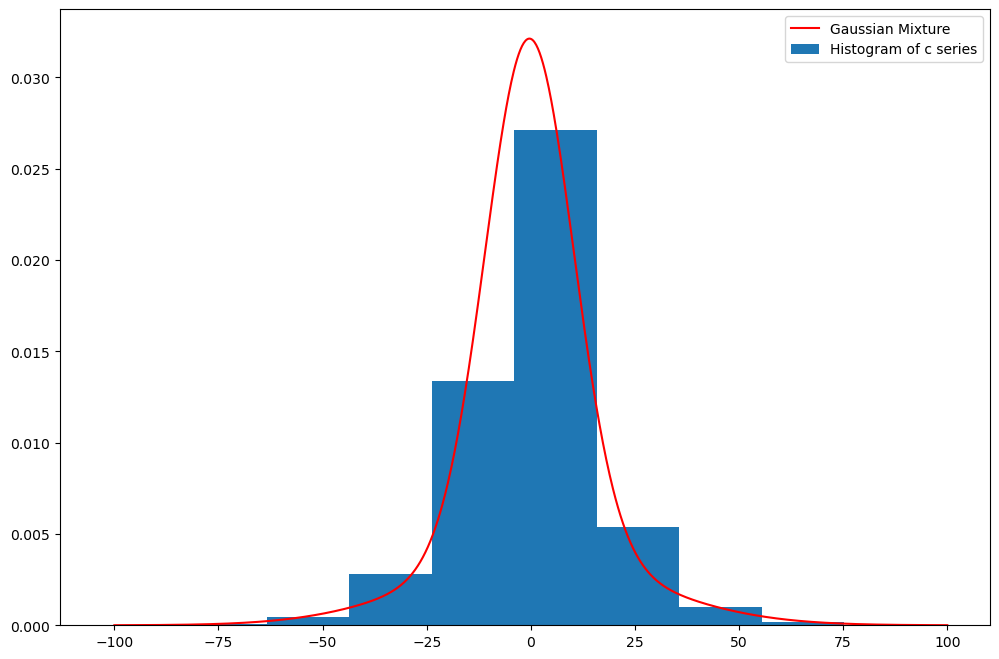

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(-100, 100, 1000).reshape(-1, 1)
logprob = mixture.score_samples(x)
pdf = np.exp(logprob)
ax.plot(x, pdf, color='red', label='Gaussian Mixture')
ax.hist(c.values, density=True, label='Histogram of c series')
ax.legend(loc='best')
plt.show()

In [99]:
def cdf_mixture(x, mixture):
    n_components = len(mixture.weights_)
    cdf_x = [norm(mixture.means_[i], np.sqrt(mixture.covariances_.flatten()[i])).cdf(x) for i in range(n_components)]

    return np.dot(mixture.weights_, cdf_x)

In [100]:
def compute_gmm_bet_size(c):
    cdf_c = cdf_mixture(c, mixture)
    cdf_0 = cdf_mixture(0, mixture)
    
    if c >= 0:
        return (cdf_c - cdf_0) / (1 - cdf_0)
    else:
        return (cdf_c - cdf_0) / cdf_0

In [101]:
avg_bet_df['gmm_bet_size'] = avg_bet_df.concurrence_based_bet_size.apply(compute_gmm_bet_size)

#### Discretization Bet Sizing

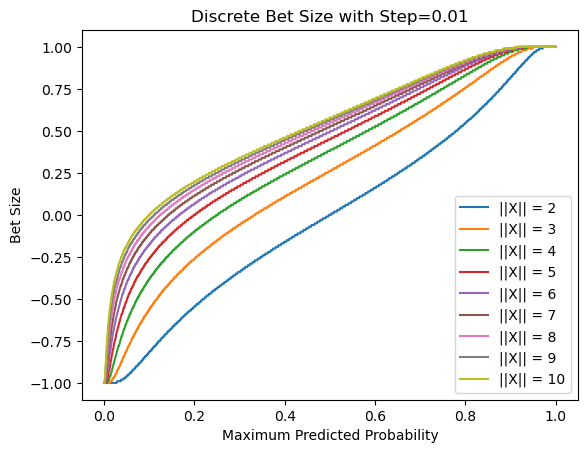

In [108]:
step_size = 0.01

fig, ax = plt.subplots()
probs = np.linspace(0, 1, 1000)
probs = probs[1:-1]
for d in range(2, 11):
    z_stats = [compute_z(p, d) for p in probs]
    sizes = [bet_size(z) for z in z_stats]
    discrete_size = np.round(np.array(sizes) / step_size) * step_size
    ax.plot(probs, discrete_size, label="||X|| = {}".format(d))
ax.set_xlabel("Maximum Predicted Probability")
ax.set_ylabel("Bet Size".format(step_size))
ax.set_title("Discrete Bet Size with Step={}".format(step_size))
ax.legend()
plt.show()

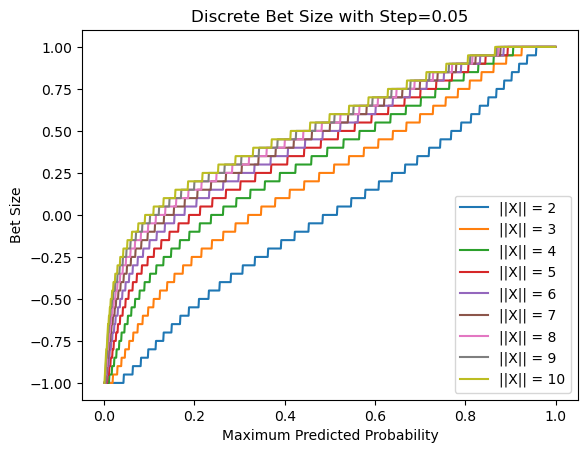

In [132]:
step_size = 0.05

fig, ax = plt.subplots()
probs = np.linspace(0, 1, 1000)
probs = probs[1:-1]
for d in range(2, 11):
    z_stats = [compute_z(p, d) for p in probs]
    sizes = [bet_size(z) for z in z_stats]
    discrete_size = np.round(np.array(sizes) / step_size) * step_size
    ax.plot(probs, discrete_size, label="||X|| = {}".format(d))
ax.set_xlabel("Maximum Predicted Probability")
ax.set_ylabel("Bet Size".format(step_size))
ax.set_title("Discrete Bet Size with Step={}".format(step_size))
ax.legend()
plt.show()

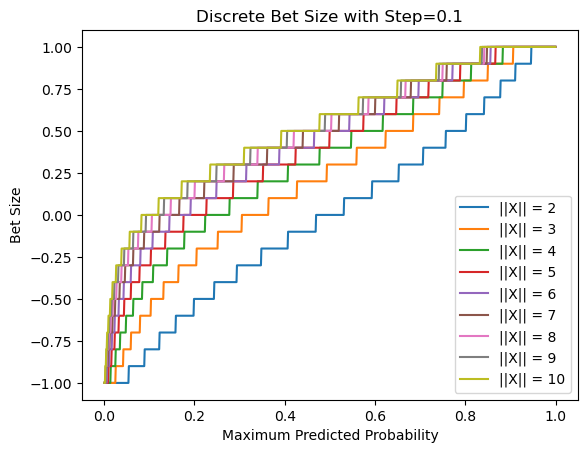

In [133]:
step_size = 0.1

fig, ax = plt.subplots()
probs = np.linspace(0, 1, 1000)
probs = probs[1:-1]
for d in range(2, 11):
    z_stats = [compute_z(p, d) for p in probs]
    sizes = [bet_size(z) for z in z_stats]
    discrete_size = np.round(np.array(sizes) / step_size) * step_size
    ax.plot(probs, discrete_size, label="||X|| = {}".format(d))
ax.set_xlabel("Maximum Predicted Probability")
ax.set_ylabel("Bet Size".format(step_size))
ax.set_title("Discrete Bet Size with Step={}".format(step_size))
ax.legend()
plt.show()